# Exploring encoding performance as a function of latent dimensions for CAE
* After approx. 50 epochs both validation and train loss saturate.
* There seems to be no overfitting (even after 1000 epochs), MSE saturates. 
* For latent width > 64 MSE is virtually 0.  
    * Thus 64 latent dimensions (i.e. nonlinear "principle axes") are enough to reconstruct the data withouth loss. (Upper limit for MNIST on this architecture)
    * Is MSE really a good measure for reconstruction performance?

In [1]:
import keras
import keras.backend as K
import matplotlib.pyplot as plt; plt.gray()
%matplotlib inline
import numpy as np; np.random.seed(1)
import tensorflow as tf

In [2]:
nepochs    = 50
batch_size = 32

### 1. Generate data

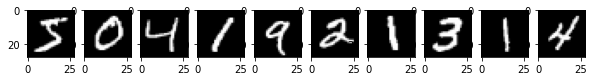

In [3]:
nrows, ncols = 28, 28
(X_train, _), (X_test, _) = keras.datasets.mnist.load_data() # load
X_train, X_test = tf.reshape(X_train, (-1,nrows,ncols,1)), tf.reshape(X_test, (-1,nrows,ncols,1)) # reshape
X_train, X_test = tf.cast(X_train, 'float32') / 255., tf.cast(X_test, 'float32') / 255.  # MinMax scale

fig, axs = plt.subplots(1, 10, figsize=(10,1))
for (i, ax) in enumerate(axs):
    ax.imshow(tf.reshape(X_train[i], (nrows, ncols)), vmin=0, vmax=1)

### 2. Create model
* To avoid vanishing gradients at larger model capacity (with sigmoid happens at latent_dims > 256) we use relu instead of sigmoid here.

In [4]:
def build_encoder(n):
    return keras.Sequential([
        keras.layers.Input(shape=(nrows,ncols,1)),
        keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='same', activation='relu', use_bias=False),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='same', activation='relu', use_bias=False),
        keras.layers.Flatten(),
        keras.layers.Dense(units=n, activation='linear', use_bias=False),
    ])

def build_decoder(n):
    return keras.Sequential([
        keras.layers.Input(shape=(n,)),
        keras.layers.Dense(units=nrows//4*ncols//4*16, activation='relu', use_bias=False), # add units to avoid bottleneck forming here.
        keras.layers.Reshape(target_shape=(nrows//4,ncols//4,16)),      # .. reshape those units into channel dimension.
        keras.layers.Conv2DTranspose(filters=8, kernel_size=4, strides=2, padding='same', activation='relu', use_bias=False),
        keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding='same', activation='linear', use_bias=False),
    ])

### 3. Train model

[0.063458055, 0.04618169, 0.0323525, 0.019779637, 0.01000004, 0.0051274276, 0.0026577734, 0.0013480633, 0.0005176444, 0.00031046013, 0.000797548]


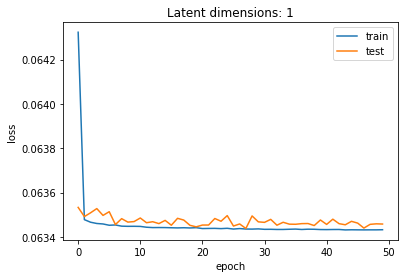

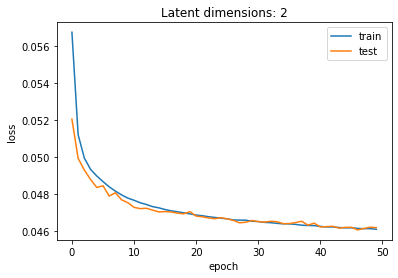

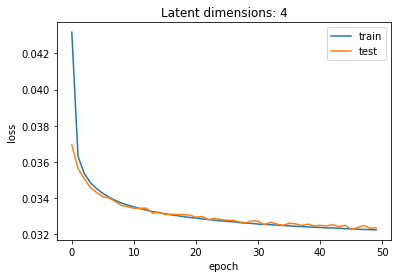

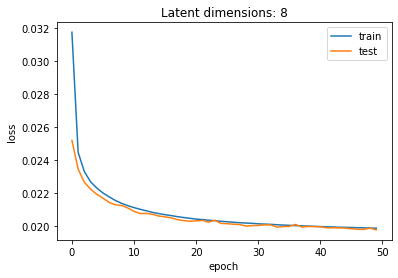

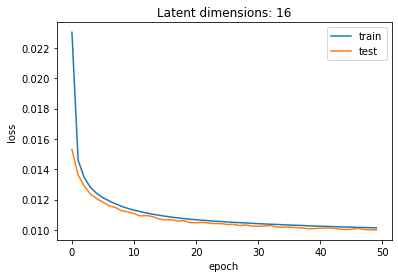

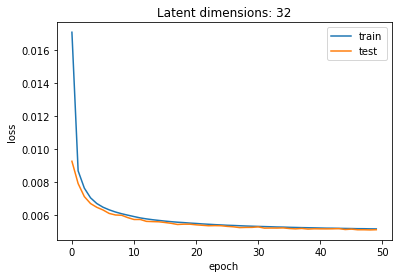

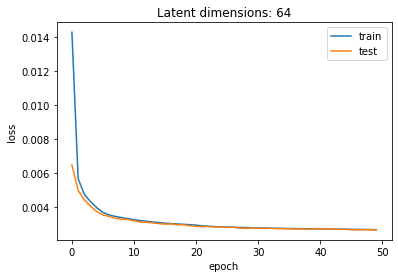

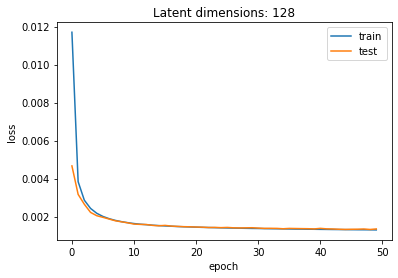

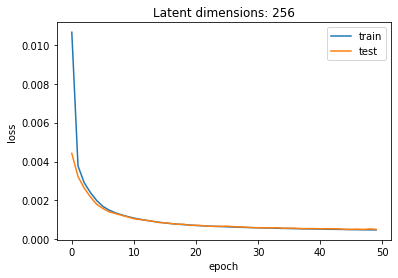

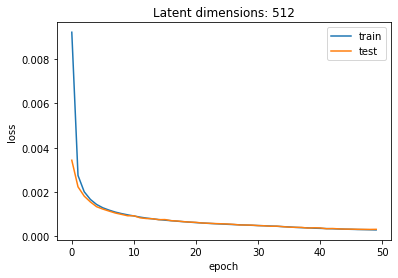

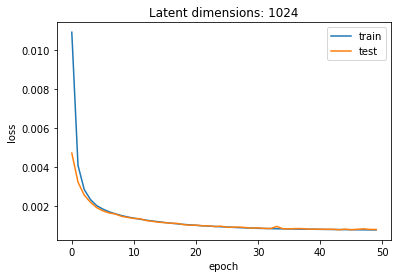

In [5]:
mses = []
ncomponents = [2**i for i in range(11)]

for i in ncomponents:
    cae = keras.Sequential([build_encoder(i), build_decoder(i)])
    cae.compile(loss='mse', optimizer='adam')
    history = cae.fit(X_train, X_train, 
                      validation_data=(X_test, X_test),
                      epochs=nepochs, batch_size=batch_size, verbose=0)
    
    fig, ax = plt.subplots()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.title(f'Latent dimensions: {i}')
    
    X_pred = cae.predict(X_test)
    mses.append(np.square(np.subtract(X_test, X_pred)).mean()) # evaluate and add test MSE.

print(mses)

### 4. Plot saturated MSE as function of latent dimensions
* For latent dims >49 the bottleneck is on the first decoder dense layer.
    * Thus we add some units which we then reshape to filters as input to first conv layer.

Text(0, 0.5, 'Saturated MSE (test set)')

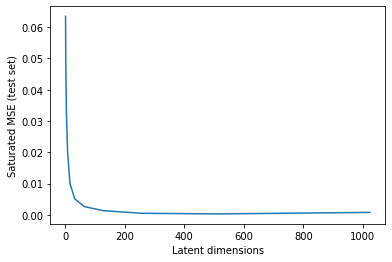

In [6]:
plt.plot(ncomponents, mses)
plt.xlabel("Latent dimensions")
plt.ylabel("Saturated MSE (test set)")